<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:           transactions   No. Observations:                   61
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -230.701
Date:                Thu, 07 Dec 2017   AIC                            465.402
Time:                        17:34:44   BIC                            469.623
Sample:                    03-02-2017   HQIC                           467.056
                         - 05-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9271      0.061    -15.250      0.000      -1.046      -0.808
sigma2       123.8916     23.053      5.374      0.000      78.708     169.075
===================================================================================
Ljung-Box (Q):                       24.47   Jarque-Bera (JB):                 0.97
Prob(Q):                              0.97   Prob(JB):                         0.61
Heteroskedasticity (H):               0.75   Skew:                             0.27
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

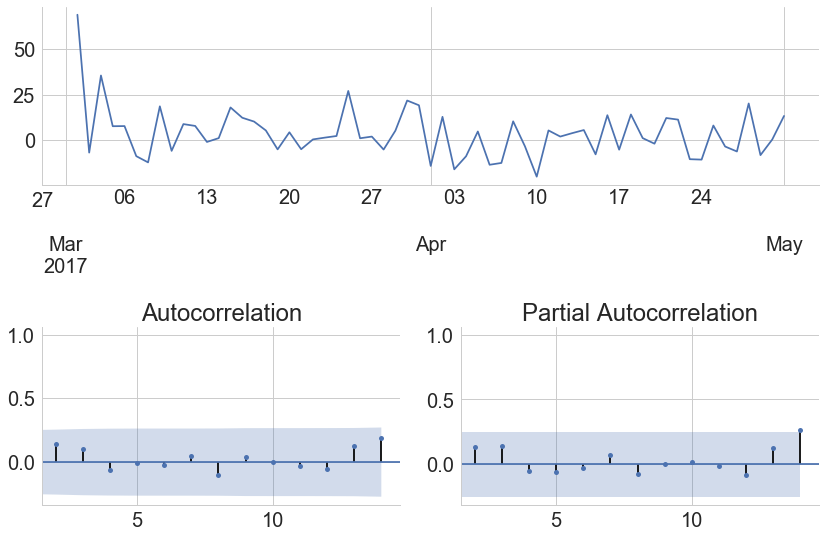

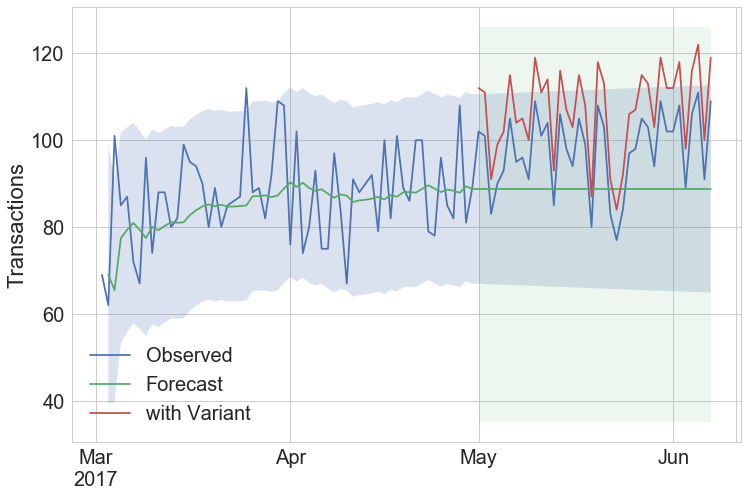

In [420]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.tsa.api as smt
from scipy.stats import boxcox, kstest, mstats
from scipy.special import inv_boxcox
from utils import poisson_process, plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook', palette='deep',
        font_scale=2, rc={'figure.figsize': [12, 8]})

df = poisson_process.nhpp(
    λ=100, n=10000, t0='2017-03-01', freq='1D', 
    thinning_components=[{'function': poisson_process._trend, 
                          'params': {'percent_increase': 1.0, 'period': 365}}]).to_frame()

treatment_start = '2017-05-01'
effect_size = 0.1
df.loc[treatment_start:, 'response'] = (
    np.random.normal(loc=effect_size, scale=0.001, size=len(df[treatment_start:])))
df['transactions_with_response'] = (df['transactions'] * (1 + df['response'].fillna(0))).astype(int)

mod = smt.SARIMAX(df.loc[:treatment_start, 'transactions'], 
                  order=(0, 1, 1), 
                  seasonal_order=(0, 0, 0, 0))
res = mod.fit()

pred = res.get_prediction(start='2017-03-03', end=max(df.index), dynamic=treatment_start)
df['prediction'] = pred.predicted_mean
df[['prediction_lower', 'prediction_upper']] = pred.conf_int()

plotting.tsplot(res.resid, lags=14)

fig = plt.figure()
ax = df['transactions'].plot(label='Observed')
df['prediction'].plot(ax=ax, label='Forecast')
ax.fill_between(df.index, df['prediction_lower'], df['prediction_upper'], alpha=0.2)
df.loc[treatment_start:, 'transactions_with_response'].plot(ax=ax, label='with Variant')
ax.fill_betweenx(ax.get_ylim(), pd.Timestamp(treatment_start), df.index[-1], alpha=0.1)
ax.set_ylabel('Transactions')
ax.legend()

res.summary()

In [425]:
df

,transactions,response,transactions_with_response,prediction,prediction_lower,prediction_upper
2017-03-02,69,NaN,69,NaN,NaN,NaN
2017-03-03,62,NaN,62,68.992077,39.244456,98.739697
2017-03-04,101,NaN,101,65.486241,39.699043,91.273439
2017-03-05,85,NaN,85,77.436271,53.100753,101.771790
2017-03-06,87,NaN,87,79.364786,55.779864,102.949708
2017-03-07,72,NaN,72,80.943691,57.813793,104.073589
2017-03-08,67,NaN,67,79.376070,56.548744,102.203395
2017-03-09,96,NaN,96,77.479206,54.865573,100.092839
2017-03-10,74,NaN,74,80.020079,57.563849,102.476309
2017-03-11,88,NaN,88,79.267253,56.930583,101.603923


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:12<00:00, 194.35it/s]


[0.17774573374748748, 0.2038929566447734, 0.23003675716991678]


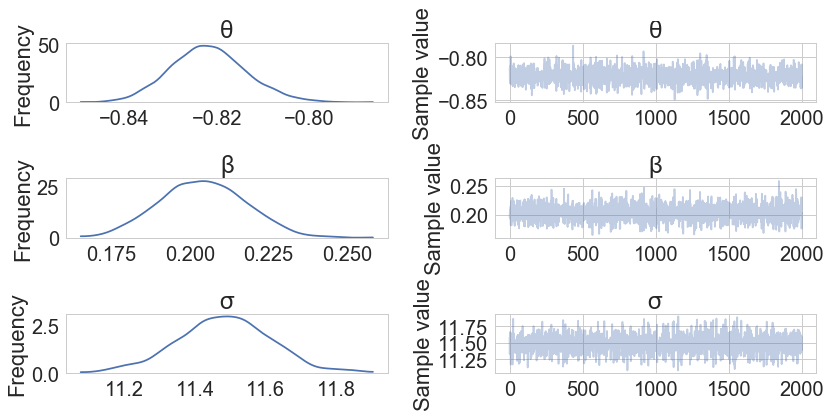

In [424]:
import pymc3 as pm
from theano import scan, shared
import theano.tensor as tt

def build_model(X, treatment_start, treatment_observations):
    time_seen = pd.to_datetime(treatment_start) + pd.DateOffset(treatment_observations - 1)
    y = shared(X[:time_seen].values)
    y_switch = shared(X[:time_seen].index < treatment_start)
    with pm.Model() as i1ma1:
        σ = pm.HalfCauchy('σ', beta=2.)
        θ = pm.Normal('θ', 0., sd=2.)
        β = pm.Normal('β', 0., sd=5.)
        
        y_adj = tt.switch(y_switch, y, y - tt.dot(y, β))
        
        ε0 = tt.zeros_like(y_adj)
        
        def calc_next(y_lag1, y_lag0, ε, θ):
            return y_lag0 - y_lag1 - θ * ε

        ε, _ = scan(fn=calc_next,
                    sequences=dict(input=y_adj, taps=[-1, 0]),
                    outputs_info=[ε0],
                    non_sequences=[θ])

        pm.Potential('like', pm.Normal.dist(0, sd=σ).logp(ε))
    return i1ma1

treatment_observations = 1
with build_model(df['transactions_with_response'], 
                 treatment_start, 
                 treatment_observations):
    trace = pm.sample(2000)

pm.traceplot(trace, combined=True)
print('[{lower}, {expectation}, {upper}]'.format(
    expectation=trace['β'].mean(),
    lower=np.percentile(trace['β'], (1 - 0.95) / 2 * 100),
    upper=np.percentile(trace['β'], (1 - (1 - 0.95) / 2) * 100)))

In [5]:
import pymc3 as pm
import theano.tensor as tt

def linear_regression(X, y):
    with pm.Model() as model:
        w = pm.Flat('w', shape=2)
        σ = pm.HalfCauchy('σ', beta=10.)
        y_obs = pm.Normal('y', mu=tt.dot(X, w), sd=σ, observed=y.squeeze())
    return model

class PyMCModel(object):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        with self.model(X, y):
            self.trace_ = pm.sample(2000)
        return self
    
    def predict(self, X):
        return X.dot(self.trace_['w'].T)

control = df[:treatment_start]
X_control = np.array([np.ones(len(control)), control['relative_days']]).T
lr_control = PyMCModel(linear_regression).fit(X_control, control['residuals'])

X = np.array([np.ones(len(df)), df['relative_days']]).T
fit_control = lr_control.predict(X)
fit_control
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:04<00:00, 558.94it/s]


array([[  1.27334721,   4.87445719,  -1.67325307, ...,  13.79310088,
        -11.6255669 , -13.17880786],
       [  1.72040345,   4.72313037,  -1.1770965 , ...,  13.93919072,
        -10.73258287, -12.14246056],
       [  2.1674597 ,   4.57180355,  -0.68093993, ...,  14.08528057,
         -9.83959884, -11.10611327],
       ..., 
       [ 31.22611556,  -5.26443958,  31.56923711, ...,  23.58112059,
         48.20436304,  56.25646078],
       [ 31.6731718 ,  -5.4157664 ,  32.06539368, ...,  23.72721043,
         49.09734707,  57.29280807],
       [ 32.12022805,  -5.56709322,  32.56155025, ...,  23.87330028,
         49.99033109,  58.32915536]])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:04<00:00, 586.53it/s]


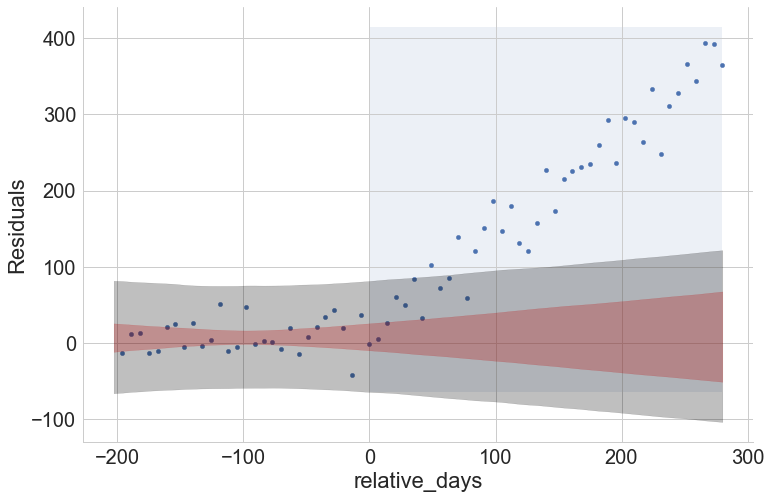

In [103]:
import pymc3 as pm
import theano.tensor as tt

def interrupted_time_series(X, y):
    with pm.Model() as model:
        w = pm.Flat('w', shape=2)
        σ = pm.HalfCauchy('σ', beta=10.)
        y_obs = pm.Normal('y', mu=tt.dot(X, w), sd=σ, observed=y.squeeze())
    return model

class PyMCModel(object):
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        with self.model(X, y):
            self.trace_ = pm.sample(2000)
        return self
    
    def predict(self, X):
        return X.dot(self.trace_['w'].T)

control = df[:treatment_start]
X_control = np.array([np.ones(len(control)), control['relative_days']]).T
lr_control = PyMCModel(linear_regression).fit(X_control, control['residuals'])

X = np.array([np.ones(len(df)), df['relative_days']]).T
fit_control = lr_control.predict(X)

ax = df.plot(x='relative_days', y='residuals_with_response', kind='scatter')

# Highlight the forecast area
ax.fill_betweenx(ax.get_ylim(), 0, max(df['relative_days']), alpha=.1, zorder=-1)

# Best Fit Control Line
ax.fill_between(df['relative_days'],
                np.percentile(fit_control, q=2.5, axis=1),
                np.percentile(fit_control, q=97.5, axis=1), 
                color='r', alpha=.25)
ax.fill_between(df['relative_days'],
                np.percentile(fit_control - 2 * lr_control.trace_['σ'], q=2.5, axis=1),
                np.percentile(fit_control + 2 * lr_control.trace_['σ'], q=97.5, axis=1), 
                color='k', alpha=.25)    

plt.ylabel('Residuals')
sns.despine()



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:03<00:00, 781.43it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 97%|█████████▋| 2418/2500 [00:02<00:00, 905.09it/s]/Users/drew/anaconda3/envs/ts-exp/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2500/2500 [00:02<00:00, 905.88it/s]


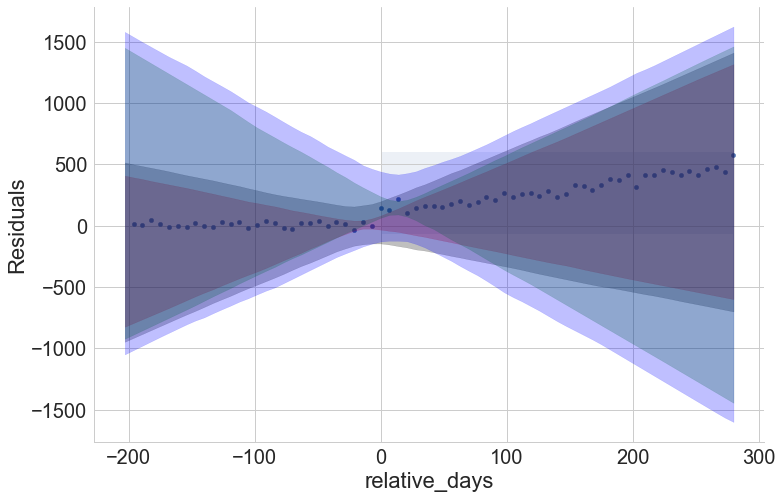

In [17]:
n_days = 5

control = df[:treatment_start][-n_days:]
X_control = np.array([np.ones(len(control)), control['relative_days']]).T
lr_control = PyMCModel(linear_regression).fit(X_control, control['residuals'])

X = np.array([np.ones(len(df)), df['relative_days']]).T
fit_control = lr_control.predict(X)

treatment = df[treatment_start:][:n_days]
X_treatment = np.array([np.ones(len(treatment)), treatment['relative_days']]).T
lr_treatment = PyMCModel(linear_regression).fit(X_treatment, treatment['residuals_with_response'])

X = np.array([np.ones(len(df)), df['relative_days']]).T
fit_treatment = lr_treatment.predict(X)

ax = df.plot(x='relative_days', y='residuals_with_response', kind='scatter')

# Highlight the forecast area
ax.fill_betweenx(ax.get_ylim(), 0, max(df['relative_days']), alpha=.1, zorder=-1)

# Best Fit Control Line
ax.fill_between(df['relative_days'],
                np.percentile(fit_control, q=2.5, axis=1),
                np.percentile(fit_control, q=97.5, axis=1), 
                color='r', alpha=.25)
ax.fill_between(df['relative_days'],
                np.percentile(fit_control - 2 * lr_control.trace_['σ'], q=2.5, axis=1),
                np.percentile(fit_control + 2 * lr_control.trace_['σ'], q=97.5, axis=1), 
                color='k', alpha=.25)   

# Best Fit Treatment Line
ax.fill_between(df['relative_days'],
                np.percentile(fit_treatment, q=2.5, axis=1),
                np.percentile(fit_treatment, q=97.5, axis=1), 
                color='g', alpha=.25)
ax.fill_between(df['relative_days'],
                np.percentile(fit_treatment - 2 * lr_treatment.trace_['σ'], q=2.5, axis=1),
                np.percentile(fit_treatment + 2 * lr_treatment.trace_['σ'], q=97.5, axis=1), 
                color='b', alpha=.25)   

# plt.ylim([-25, 100])
plt.ylabel('Residuals')
sns.despine()

(-4, 5)

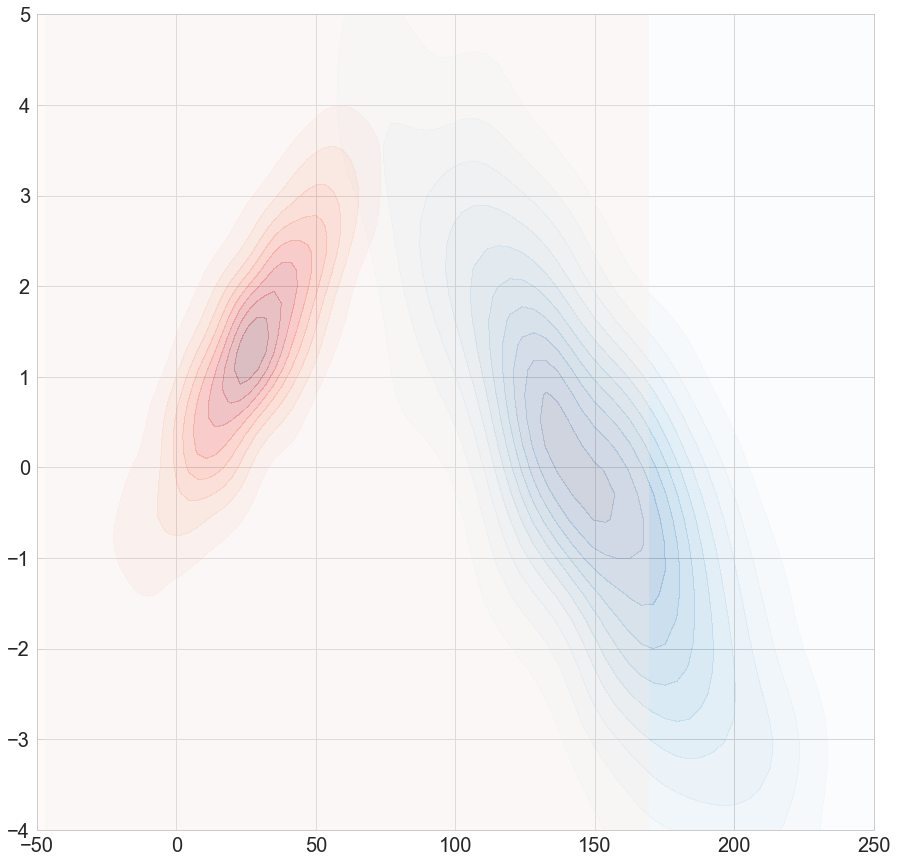

In [22]:
sns.set(style='whitegrid', context='notebook', palette='deep',
        font_scale=2, rc={'figure.figsize': [15, 15]})
ax = sns.kdeplot(lr_treatment.trace_['w'].T[0], lr_treatment.trace_['w'].T[1], shade=True, cmap='Blues', alpha=0.25)
ax = sns.kdeplot(lr_control.trace_['w'].T[0], lr_control.trace_['w'].T[1], shade=True, cmap='Reds', alpha=0.25)
ax.set_xlim(-50, 250)
ax.set_ylim(-4, 5)